In [14]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from fingerprint import FPS
import io
import lightgbm as lgb
from PIL import Image
import matplotlib.pyplot as plt

### 加载数据和模型

In [10]:
RESULT_ROOT = '../result/visualize'
data_IC50 = '../data/train_data/data_xhg_20220602.csv'
fps_path = '../data/train_data/TIGIT_trisython_smi_low.h5'
index = ['1','2','3','4','5']

df_data = pd.read_csv(data_IC50)
df_data = df_data[['IC50_']]
f = FPS(fpsize=2048,radius=3)

smis = []

for ID in index:
    smi = df_data.iloc[int(ID)]['IC50_']
    smi = smi[:smi.find('<')]
    smis.append(smi)

fps = f.get_fps(smis)
model = lgb.Booster(model_file='/home/ubuntu/project/tigit/result/2022-06-22/light_GBM/model.h5')

100%|██████████| 5/5 [00:00<00:00, 255.71it/s]


### 预测

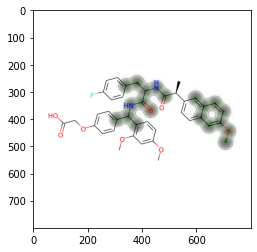

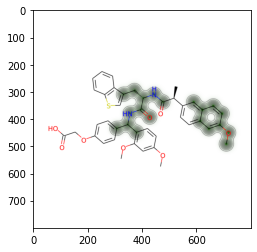

/home/ubuntu/miniconda3/envs/chemprop/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


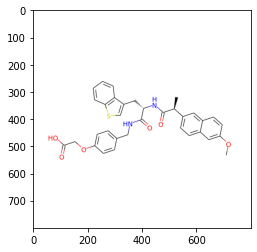

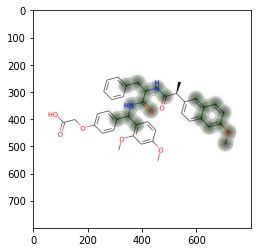

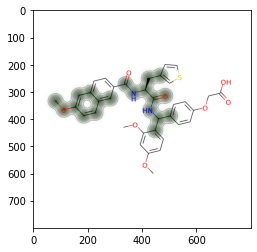

In [16]:
result = []

def get_predict_result(fp):
    score = model.predict(np.array(fp).reshape(1,2048))
    return score

def show(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    plt.imshow(img)
    plt.show()

for i, smi in enumerate(smis):
    dim = int(800)
    d = Draw.MolDraw2DCairo(dim, dim)
    d.SetFontSize(0.85)
    mol = Chem.MolFromSmiles(smi) 
    weights = SimilarityMaps.GetAtomicWeightsForModel(mol,f.sim_featurizer,
        lambda fp: np.squeeze(get_predict_result(fp)),
    )
    scale = max(weights)
    SimilarityMaps.GetSimilarityMapFromWeights(mol, [w/scale for w in weights], draw2d=d)
    d.FinishDrawing()
    show(d.GetDrawingText())